### 必要な麻雀関連の関数の定義

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import time


from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model


random_seed = 34
np.random.seed(random_seed)

In [0]:
from collections import defaultdict
def is_valid(seq, l=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > l): return False # 牌の上限枚数を超えたらFalse
    return True

import itertools
def number_state_slow(n,m,l): # 全ての手牌の組み合わせの数を出力する関数
    count = 0
    for seq in itertools.product(range(n), repeat = m): # 直積を作る関数, n=9 m=5 なら 9 ** 5 回繰り返す　
        if is_valid(seq,l):
            count += 1
            #print(list(seq))
    return count
    
def generate_all_l(n, m, l=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(n), repeat = m):
        if is_valid(seq, l):
            gen_list.append(seq)
    return gen_list

def states_to_hist(state_list, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        ret = [0] * n # ret = [0,0,...,0]
        for c in state:
            ret[c] += 1
        hist_list.append(ret)
    return hist_list

def hand_to_prob_and_state(hand, state_nml, n, m, l=4): # ある手牌(hand)における、1枚ツモる時の遷移確率(prob)と手牌(state)のindexのタプルを出す関数
    #print(state_nml)
    ret = [l] * n  #  残り枚数を表すリスト
    for h in hand:
        ret[h] -= 1
    yama_sum = n * l - (m - 1)
    state_list = []
    for i in range(n):
        if ret[i] == 0: 
            continue
        prob = ret[i] / yama_sum # 遷移確率
        state = tuple(sorted(list(hand) + [i])) # 遷移後の手牌
        #print(state)
        state_index = state_nml.index(state) # 遷移後の手牌のindex
        #print(state_index)
        state_list.append((prob, state_index))
    return state_list

def state_to_hand(state): # ある手牌stateに遷移できるhandを出力する関数
    return list(set(tuple(state[:i] + state[i+1:]) for i in range(len(state)))) # i番目の要素を取り除く

def is_win_sub(hist, two, three):
    if any(x < 0 for x in hist):
        return False # この行を消したかったら、順子判定のところで手牌の枚数が負になるものを弾いておく
    if two == 0 and three == 0:
        return True
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    if two > 0 and hist[i] >= 2 and is_win_sub([x - 2 if i == j else x for j, x in enumerate(hist)], two - 1, three): # 雀頭
        return True
    if three > 0 and hist[i] >= 3 and is_win_sub([x - 3 if i == j else x for j, x in enumerate(hist)], two, three - 1): # 刻子
        return True
    if three > 0 and i + 2 < len(hist) and is_win_sub([x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)], two, three - 1): # 順子
        return True
    return False

def is_win_main(hist):
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    return is_win_sub(hist, n_two, n_three)

def value_iteration(n, m, l, gamma):
    state_nml = generate_all_l(n, m, l)
    hand_nml = generate_all_l(n, m-1, l)
    hist_nml = states_to_hist(state_nml, n)
    is_win_nml = [is_win_main(hist) for hist in hist_nml]
    h2ps_nml = [hand_to_prob_and_state(hand, state_nml, n, m, l) for hand in hand_nml]
    s2h_nml = [[hand_nml.index(hand) for hand in state_to_hand(state)] for state in state_nml]
    value_hand = [0] * len(hand_nml)
    n_hand = len(hand_nml)
    value_state = [1 if is_win_nml[i] else 0 for i in range(len(state_nml))] # あがっていればvalueは1、いなければ0
    n_state = len(state_nml)
    theta = 1e-6
    while True:
        print('iteration')
        delta = 0
        for i in range(n_hand):
            old_v = value_hand[i]
            value_hand[i] = sum(p * value_state[n] for (p, n) in h2ps_nml[i])
            delta = max(delta, abs(old_v - value_hand[i]))
        if delta < theta: break
        for i in range(n_state):
            if is_win_nml[i]: continue
            value_state[i] = max(gamma * value_hand[n] for n in s2h_nml[i])
    return value_hand
  
def one_hot_vector1(hands, n): # 手牌の中の牌一つ一つをone-hotにした(手牌１つがn * m-1の行列に対応)
    results = np.zeros((len(hands), n, len(hands[0])))
    for i in range(len(hands)):
        for j, hand_i in enumerate(hands[i]):
            results[i][hand_i][j] = 1
    return results

def one_hot_vector2(hists, n, l=4): # histをそのままone-hotにした(手牌１つがn * l + 1の行列に対応)
    results = np.zeros((len(hists), n, l + 1))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            results[i][j][hist_i] = 1
    return results

def one_hot_vector3(hists, n, l=4): # 上に近いけど、持ってる枚数より小さい数も1で埋めた(手牌１つがn * lの行列に対応)
    results = np.zeros((len(hists), n, l))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            if hist_i == 0:
                continue
            else:
                results[i][j][:hist_i] = 1
    return results

def state_to_hist(state, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist = [0] * n # hist = [0,0,...,0]
    for c in state:
        hist[c] += 1
    return hist

# stateとその時にvalueが最大となる捨て牌のタプルを入れたリスト max_value_discard_list = [((0, 0, 0, 0, 1), {0}), ((0, 0, 0, 0, 2), {0}), ... ,((7, 8, 8, 8, 8), {8})]
# state_nmlのうち、あがり形を抜いたもの discard_state_nml = [(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), ..., (7, 8, 8, 8, 8)]
def states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l=4):
    max_value_list = []
    discard_state_nml = []
    hist_nml = states_to_hist(state_nml, n)
    for i, hist in enumerate(hist_nml):        
        if is_win_main(hist):
            continue # あがっているstateの時は何も入れない
        else:
            max_value = 0
            max_p = []
            for j in range(m):
                state = state_nml[i]
                hand = state[:j] + state[j+1:]
                ind = hand_nml.index(tuple(hand))
                hand_val = value_hand_nml[ind]
                if max_value < hand_val:
                    max_p = {state[j]}
                    max_value = hand_val
                elif round(max_value, 5) == round(hand_val, 5): # 小数点以下5桁まで同じなら同じとみなす
                    max_p.add(state[j])
            discard_state_nml.append(state_nml[i])
            max_value_list.append(tuple((state_nml[i], max_p)))
    return max_value_list, discard_state_nml # 正直discard_hist_nmlを出す方が早い

# 各stateにおいて、出力してほしい捨て牌の確率分布を出力する
def discard_ans_prob_vector(max_value_discard_list, n, m, l):
    discard_vector = []
    for i, discard in max_value_discard_list:
        v = [0] * n
        num = len(discard)
        for p in discard:
            v[p] = 1 / num # 答えの数で割った値を教師とする  こうしないと学習がうまくいかない?
            #v[p] = 1
        discard_vector.append(v)
    return discard_vector

### 捨て牌ベクトルの作成

In [51]:
n = 9
m = 5
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
state_nml = generate_all_l(n, m, l)
hand_nml = generate_all_l(n, m - 1, l)

n = 34
max_value_discard_list, discard_state_nml = states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l)
#for i in max_value_discard_list: print(i) 
discard_hist_nml = states_to_hist(discard_state_nml, n)
discard_ans_vector_nml = np.array(discard_ans_prob_vector(max_value_discard_list, n, m, l))
#print(discard_ans_vector_nml[:5])

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


 ### Policy Networkに必要な関数の定義

In [0]:
class PrintDot(keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
        
    def on_epoch_end(self, epoch, logs):
        if epoch % (self.epochs // 5) == 0: print(logs.get('loss'))
        if epoch % 10 == 0: print('.', end='')

# discard_state_nmlをone_hot化する関数
def one_hot(discard_state_nml, num):
    if num == 1:
        return one_hot_vector1(discard_state_nml, n)
    elif num == 2:
        discard_hist_nml = states_to_hist(discard_state_nml, n)
        return one_hot_vector2(discard_hist_nml, n, l)
    else:
        discard_hist_nml = states_to_hist(discard_state_nml, n)
        return one_hot_vector3(discard_hist_nml, n, l)

# predictionsから求めた捨て牌のリストを返す関数
def make_pred_arg_list_split(predictions, discard_state_test):
    pred_arg_list = []
    for i  in range(len(predictions)):
        tile = np.argmax(predictions[i])
        if tile not in discard_state_test[i]:
            max_val = 0
            max_tile = 0
            for t in discard_state_test[i]:
                if predictions[i][t] > max_val:
                    max_val = predictions[i][t]
                    max_tile = t
            tile = max_tile
        pred_arg_list.append(tile)
    return pred_arg_list

# 正解率を返す関数
def acc_score_split(pred_arg_list, discard_state_test): 
    tr_count = 0
    fal_count = 0
    for i, pred_arg in enumerate(pred_arg_list):
        #print(i, j)
        for state, discard_set in max_value_discard_list:
            if discard_state_test[i] == state:
                if pred_arg in discard_set:
                    tr_count += 1
                else:
                    fal_count += 1
    print('true count {}  false count {}'.format(tr_count, fal_count))
    print('accuracy rate', tr_count / (tr_count + fal_count))
    return tr_count / (tr_count + fal_count)

### train

ResNet14_v1
one_hot_discard_state_train shape(x_train shape): (857, 34, 4, 1)
857 train samples
286 test samples
discard_ans_vector_train shape(y_train shape): (857, 34)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 34, 4, 1)     0                                            
__________________________________________________________________________________________________
conv2d_447 (Conv2D)             (None, 34, 4, 16)    160         input_31[0][0]                   
__________________________________________________________________________________________________
batch_normalization_389 (BatchN (None, 34, 4, 16)    64          conv2d_447[0][0]                 
__________________________________________________________________________________________________
activation_389 (Activation)     (None,

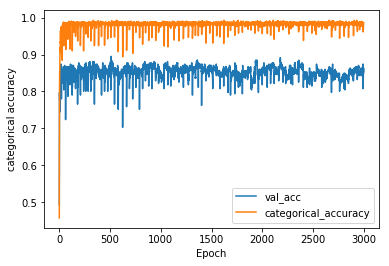

In [66]:
# Training parameters
batch_size = 8  # orig paper trained all networks with batch_size=128
EPOCHS = 3000
num_classes = n
num = 3

depth_num = 2

# Computed depth from supplied model parameter n
depth = depth_num * 6 + 2

# Model name, depth and version(Orig paper: version = 1 (ResNet v1))
model_type = 'ResNet%d_v1' % (depth)
print(model_type)

discard_state_train, discard_state_test, discard_ans_vector_train, discard_ans_vector_test = train_test_split(discard_state_nml, discard_ans_vector_nml, test_size=0.25)
one_hot_discard_state_train = one_hot(discard_state_train, num).reshape(len(discard_state_train), n, l, 1)
one_hot_discard_state_test = one_hot(discard_state_test, num).reshape(len(discard_state_test), n, l, 1)
#print(discard_ans_vector_test[:5])

# Input image dimensions.
input_shape = one_hot_discard_state_train.shape[1:]
# if input_shape != (n, l, 1):
#     raise Exception

print('one_hot_discard_state_train shape(x_train shape):', one_hot_discard_state_train.shape)
print(one_hot_discard_state_train.shape[0], 'train samples')
print(one_hot_discard_state_test.shape[0], 'test samples')
print('discard_ans_vector_train shape(y_train shape):', discard_ans_vector_train.shape)


def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
    
    x = conv(inputs)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x


def resnet_v1(input_shape, depth, num_classes=n):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (cifar10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    # x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy', 'categorical_accuracy'])
model.summary()

# Run training
plt.figure()
start_time = time.time()
history = model.fit(one_hot_discard_state_train, discard_ans_vector_train,
                  batch_size=batch_size,
                  epochs=EPOCHS,
                  callbacks=[PrintDot(EPOCHS)],
                  validation_data=(one_hot_discard_state_test, discard_ans_vector_test),
                  shuffle=True,
                  verbose=0)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n',hist.tail())

plt.plot(hist['epoch'], hist['val_acc'])
plt.plot(hist['epoch'], hist['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('categorical accuracy')
plt.legend()

print(round(time.time() - start_time, 1))

# Score trained model.
scores = model.evaluate(one_hot_discard_state_test, discard_ans_vector_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

### train2

In [0]:
# Training parameters
batch_size = 8  # orig paper trained all networks with batch_size=128
EPOCHS = 3000
num_classes = n
num = 3

depth_num = 2

# Computed depth from supplied model parameter n
depth = depth_num * 6 + 2

# Model name, depth and version(Orig paper: version = 1 (ResNet v1))
model_type = 'ResNet%d_v1' % (depth)
print(model_type)

def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = conv(inputs)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x


def resnet_v1(input_shape, depth, num_classes=n):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (cifar10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    # x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

repeat_num = 3
plt.figure()
sum_acc_result = pd.Series([0] * EPOCHS)
sum_val_acc_result = pd.Series([0] * EPOCHS)
sum_test_loss = []
sum_test_acc = []
for i in range(repeat_num):

    discard_state_train, discard_state_test, discard_ans_vector_train, discard_ans_vector_test = train_test_split(discard_state_nml, discard_ans_vector_nml, test_size=0.25)
    one_hot_discard_state_train = one_hot(discard_state_train, num).reshape(len(discard_state_train), n, l, 1)
    one_hot_discard_state_test = one_hot(discard_state_test, num).reshape(len(discard_state_test), n, l, 1)
    #print(discard_ans_vector_test[:5])

    # Input image dimensions.
    input_shape = one_hot_discard_state_train.shape[1:]

    if i ==0:
        print('one_hot_discard_state_train shape(x_train shape):', one_hot_discard_state_train.shape)
        print(one_hot_discard_state_train.shape[0], 'train samples')
        print(one_hot_discard_state_test.shape[0], 'test samples')
        print('discard_ans_vector_train shape(y_train shape):', discard_ans_vector_train.shape)

    model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    if i == 0:
        model.summary()

    # Run training
    start_time = time.time()
    history = model.fit(one_hot_discard_state_train, discard_ans_vector_train,
                      batch_size=batch_size,
                      epochs=EPOCHS,
                      callbacks=[PrintDot(EPOCHS)],
                      validation_data=(one_hot_discard_state_test, discard_ans_vector_test),
                      shuffle=True,
                      verbose=0)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print('\n',hist[-5:])
    
    sum_acc_result += hist['acc']
    sum_val_acc_result += hist['val_acc']

    print('time(sec)', round(time.time() - start_time, 1))

    # Score trained model.
    scores = model.evaluate(one_hot_discard_state_test, discard_ans_vector_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    sum_test_loss.append(scores[0])
    sum_test_acc.append(scores[1])
    print()
   
plt.plot(hist['epoch'], sum_acc_result / 3, label='categorical acc')
plt.plot(hist['epoch'], sum_val_acc_result / 3, label='valid acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

print('test_loss(mean)', sum(sum_test_loss) / 3)
print('test_accuracy(mean)', sum(sum_test_acc) / 3)

ResNet14_v1
one_hot_discard_state_train shape(x_train shape): (857, 34, 4, 1)
857 train samples
286 test samples
discard_ans_vector_train shape(y_train shape): (857, 34)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 34, 4, 1)     0                                            
__________________________________________________________________________________________________
conv2d_657 (Conv2D)             (None, 34, 4, 16)    160         input_45[0][0]                   
__________________________________________________________________________________________________
batch_normalization_571 (BatchN (None, 34, 4, 16)    64          conv2d_657[0][0]                 
__________________________________________________________________________________________________
activation_571 (Activation)     (None,